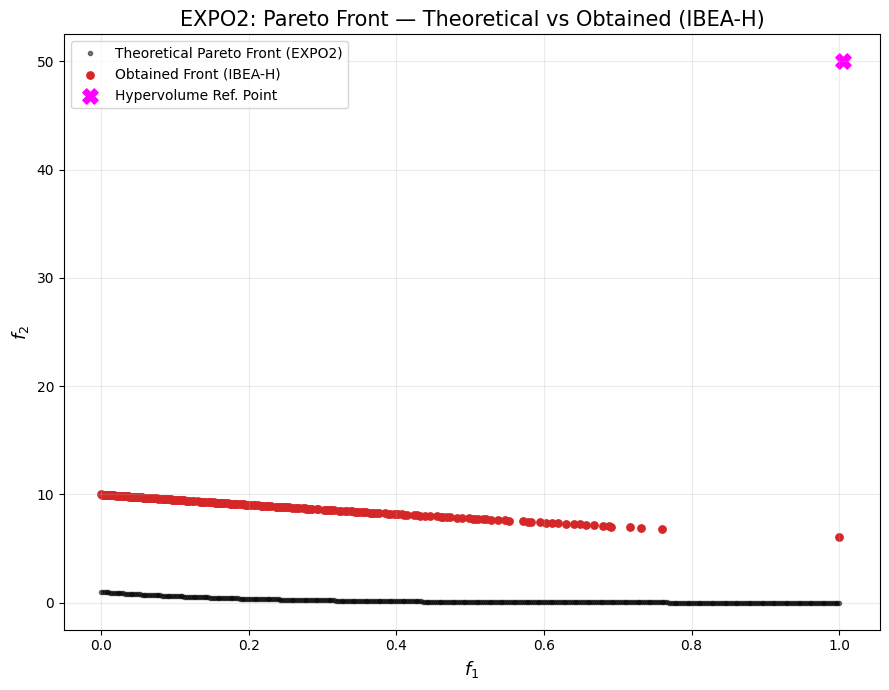

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from pymoors import (
    Ibea,                      # <- IBEA (Hypervolume-based)
    RandomSamplingFloat,
    GaussianMutation,
    SimulatedBinaryCrossover,
    CloseDuplicatesCleaner,
    Constraints,
)
from pymoors.schemas import Population
from pymoors.typing import TwoDArray


# ==============================
# EXPO2 — Objective Evaluation
# ==============================
def evaluate_expo2(x: TwoDArray) -> TwoDArray:
    """
    EXPO2 (minimization, 2 objectives).

    g(x) = 1 + (9/(n-1)) * sum_{i=2..n} x_i
    f1(x) = x1
    f2(x) = g(x) * exp( -5 * x1 / g(x) )

    Typical domain: x_i in [0, 1], i=1..n (e.g., n = 30).
    """
    n = x.shape[1]
    if n < 2:
        raise ValueError("EXPO2 requires at least 2 decision variables.")

    # g(x)
    g = 1.0 + (9.0 / (n - 1)) * np.sum(x[:, 1:], axis=1)

    f1 = x[:, 0]
    f2 = g * np.exp(-5.0 * x[:, 0] / g)

    return np.column_stack((f1, f2))


# ==========================================
# Theoretical Front (g=1 => x2..xn = 0; f2=exp(-5 f1))
# ==========================================
def expo2_theoretical_front(num_points: int = 200):
    """
    Returns (f1, f2) arrays of the EXPO2 Pareto front:
        f1 in [0, 1], f2 = exp(-5 f1)
    """
    f1 = np.linspace(0.0, 1.0, num_points)
    f2 = np.exp(-5.0 * f1)
    return f1, f2


# =============================
# Algorithm Setup (IBEA-H)
# =============================
# Problem dimensionality
NUM_VARS = 30

# Hypervolume reference point (minimization ⇒ worse-than-worst)
# Rationale: f1 ∈ [0,1]; f2 can reach ~10 when g≈10 and x1≈0.
# Use a conservative margin:
HV_REFERENCE_POINT = np.array([1.005, 50], dtype=float)

# kappa controls the selection pressure in IBEA
KAPPA = 0.005  # assuming objectives are on roughly comparable scales


algorithm = Ibea(
    sampler=RandomSamplingFloat(min=0.0, max=1.0),
    crossover=SimulatedBinaryCrossover(distribution_index=10),
    mutation=GaussianMutation(gene_mutation_rate=0.1, sigma=0.05),
    fitness_fn=evaluate_expo2,
    constraints_fn=Constraints(lower_bound=0.0, upper_bound=1.0),
    duplicates_cleaner=CloseDuplicatesCleaner(epsilon=1e-10),
    num_vars=NUM_VARS,
    population_size=200,
    num_offsprings=200,
    num_iterations=800,
    mutation_rate=0.1,
    crossover_rate=0.9,
    keep_infeasible=False,
    reference_points=HV_REFERENCE_POINT,
    kappa=KAPPA,
    verbose=False,
    seed=1729,
)

# ===============
# Run IBEA
# ===============
algorithm.run()

# Best front (Population)
best: Population = algorithm.population.best_as_population
obtained = best.fitness  # shape: (num_solutions, 2)

# =========================
# Theoretical Front & Plot
# =========================
f1_theo, f2_theo = expo2_theoretical_front(num_points=400)

plt.figure(figsize=(9, 7))

# Theoretical front
plt.plot(f1_theo, f2_theo, "k.", alpha=0.5, label="Theoretical Pareto Front (EXPO2)")

# Obtained front
plt.scatter(obtained[:, 0], obtained[:, 1], c="tab:red", s=28, label="Obtained Front (IBEA-H)")

# HV reference point (visual only)
plt.scatter([HV_REFERENCE_POINT[0]], [HV_REFERENCE_POINT[1]],
            marker="X", s=120, c="magenta", label="Hypervolume Ref. Point")

plt.xlabel(r"$f_1$", fontsize=13)
plt.ylabel(r"$f_2$", fontsize=13)
plt.title("EXPO2: Pareto Front — Theoretical vs Obtained (IBEA-H)", fontsize=15)
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


''